In [ ]:
!pip install timm
!pip install git+https://github.com/openai/CLIP.git
#!pip install keras-ocr
#!pip install tensorflow
#!pip install fuzzywuzzy
#!pip install gdown

In [2]:
from pathlib import Path
import PIL
from PIL import Image
import pandas as pd
from tqdm.notebook import tqdm
import torchvision
import torch
import pickle

In [3]:
ROOT_PATH = '/home/shared/users/ahmed-mahran/MAMI/data'

def data_root_path(is_train=True):
    tag = 'train' if is_train else 'test'
    return f"{ROOT_PATH}/{tag}"

def load_data(is_train=True, limit=None):
    # images: *.jpg
    path = data_root_path(is_train=is_train) + "/data/list.csv"
    df = pd.read_csv(path, sep='\t')
    df.rename(columns={'Text Transcription':'text_transcription'}, inplace=True)
    
    return df if limit == None else df.head(limit)

def image_path(file_name, is_train=True):
    return data_root_path(is_train=is_train) + "/data/" + file_name

def process(fn, output_name, is_train=True, limit=None, *args, **kwargs):
    output_root_path = data_root_path(is_train) + "/" + output_name
    Path(output_root_path).mkdir(parents=True, exist_ok=True)
    df = load_data(is_train, limit)
    for file_name in tqdm(df['file_name']):
        img_file = image_path(file_name, is_train)
        img = Image.open(img_file).convert('RGB')
        res = fn(img, *args, **kwargs)
        img_name, img_type = tuple(file_name.split('.'))
        for k, v in res.items():
            if isinstance(v, PIL.Image.Image):
                v.save(f'{output_root_path}/{img_name}_{k}.{img_type}')
            elif isinstance(v, torch.Tensor):
                torch.save(v, f'{output_root_path}/{img_name}_{k}.pt')
            else:
                with open(f'{output_root_path}/{img_name}_{k}.pkl', 'wb') as f:
                    pickle.dump(v, f)
                #raise ValueError(f'Unrecognized type {type(v)}')

In [35]:
df_train = load_data(is_train=True)
len([int(i.split('.')[0]) for i in list(df_train['file_name'])])

10000

In [36]:
df_test = load_data(is_train=False)
len([int(i.split('.')[0]) for i in list(df_test['file_name'])])

1000

In [37]:
x = set([int(i.split('.')[0]) for i in list(df_train['file_name'])])
y = set([int(i.split('.')[0]) for i in list(df_test['file_name'])])
[i for i in y if i in x]

[15001, 15002, 15005, 15004, 15006]

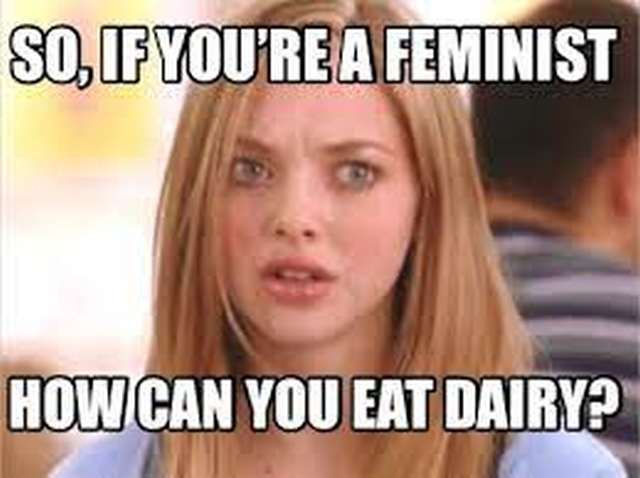

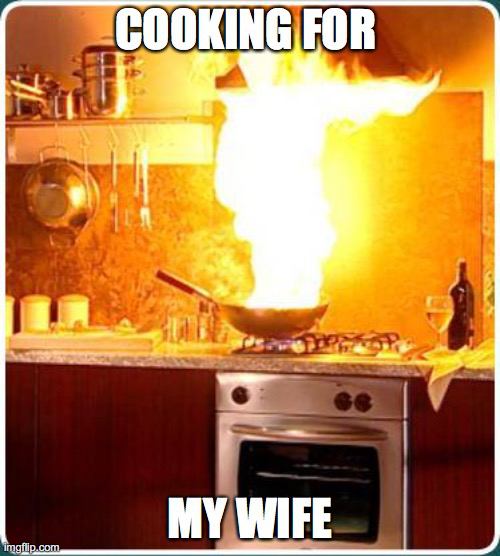

In [5]:
display(Image.open(image_path('15805.jpg', is_train=False)))
display(Image.open(image_path('15005.jpg', is_train=True)))


# Generate Grid Splits

In [4]:
def slice_image_tensor(image, patches=(2, 2)):
    """
    Slice an image tensor into nxm patches
    """
    #torch.Tensor.unfold(dimension, size, step)
    #slices the images into patches[0]*patches[1] number of patches
    
    patch_size = [l // p for l, p in zip(image[0].size(), patches)]
    # display('patch_size: ' + str(patch_size))
    
    patches = image.unfold(0, 3, 1)
    for i, lp in enumerate(patch_size):
        patches = patches.unfold(i + 1, lp, lp)
        
    return patches.squeeze(0)

def slice_image(image, patches=(2, 2)):
    sliced = slice_image_tensor(torchvision.transforms.functional.pil_to_tensor(image), patches)
    res = {}
    for i in range(patches[0]):
        for j in range(patches[1]):
            res[f'{i}_{j}'] = torchvision.transforms.functional.to_pil_image(sliced[i, j])
    return res

def read_image_slices(file_name, patches=(2, 2), is_train=True):
    root_path = data_root_path(is_train) + "/" + f'slices_{patches[0]}x{patches[1]}'
    img_name, img_type = tuple(file_name.split('.'))
    rows = []
    for i in range(patches[0]):
        cols = []
        for j in range(patches[1]):
            cols.append(Image.open(f'{root_path}/{img_name}_{i}_{j}.{img_type}'))
        rows.append(cols)
    return rows

#process(slice_image, output_name="slices_2x2", is_train=False, limit=None, patches=(2, 2))

# Generate DETR features

In [4]:
from transformers import DetrFeatureExtractor
from transformers import DetrModel
from transformers import DetrForObjectDetection

detr_model_name = "facebook/detr-resnet-50"
detr_feature_extractor = DetrFeatureExtractor.from_pretrained(detr_model_name)
# detr_model = DetrModel.from_pretrained(detr_model_name)
detr_model = DetrForObjectDetection.from_pretrained(detr_model_name)

def generate_detr_features(image):
    encoding = detr_feature_extractor(image, return_tensors="pt")
    outputs = detr_model(**encoding)
    
    img_patches_embd = outputs.last_hidden_state.squeeze(0).detach()
    img_patches_embd.requires_grad = False
    logits = outputs.logits.squeeze(0).detach()
    logits.requires_grad = False
    #print('img_patches_embd: ' + str(img_patches_embd.size()))
    return {
        'tensor': img_patches_embd, # 100 x 256
        'logits': logits # 100 x 92
    } 

def read_detr_features(file_name, is_train=True):
    root_path = data_root_path(is_train) + '/detr_features'
    img_name, img_type = tuple(file_name.split('.'))
    return {
        'tensor': torch.load(f'{root_path}/{img_name}_tensor.pt'),
        'logits': torch.load(f'{root_path}/{img_name}_logits.pt'),
    }

#process(generate_detr_features, output_name="detr_features", is_train=False, limit=None)

In [ ]:
detr_model(**detr_feature_extractor(list(torch.randint(0, 256, (2, 3, 10, 10))), return_tensors="pt"))
# detr_feature_extractor.apply

/opt/conda/lib/python3.8/site-packages/transformers/feature_extraction_utils.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = as_tensor(value)


In [13]:
image = Image.open(image_path('1.jpg', is_train=True))
display(image.size)
encoding = detr_feature_extractor(image, return_tensors="pt")
outputs = detr_model(**encoding)
display(outputs['last_hidden_state'].size())
display(outputs['encoder_last_hidden_state'].size())

(640, 585)

torch.Size([1, 100, 256])

torch.Size([1, 700, 256])

In [4]:
print(read_detr_features('15001.jpg', is_train=False)['tensor'].size())
a = read_detr_features('15001.jpg', is_train=False)['logits'].softmax(-1).argmax(-1)
print(a)
print(torch.where(a == 91, 0, 1))

torch.Size([100, 256])
tensor([91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91,
        91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91,
        91,  1, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91,
        91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91,  1,
        72, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91,  1, 91, 91,
        91, 91, 91, 91, 91, 91, 91, 91, 91, 91])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])


# Generate CLIP features

In [3]:
import clip

clip_model, preprocess = clip.load("RN50x4", jit=False)
image_size = preprocess.transforms[0].size # 288
embed_length = clip_model.ln_final.normalized_shape[0] # 640

# CLIP transforms
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=image_size, interpolation=torchvision.transforms.functional.InterpolationMode.BICUBIC, max_size=None, antialias=None),
    torchvision.transforms.CenterCrop(size=image_size),
    torchvision.transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
])

def generate_clip_features(image):
    img_patches_embd = clip_model.encode_image(image_transform(image).unsqueeze(0))
    #print('img_patches_embd: ' + str(img_patches_embd.size()))
    return {'tensor': img_patches_embd} # 1 x 640

def read_clip_features(file_name, is_train=True):
    root_path = data_root_path(is_train) + f'/clip_features'
    img_name, img_type = tuple(file_name.split('.'))
    return torch.load(f'{root_path}/{img_name}_tensor.pt')

#process(generate_clip_features, output_name="clip_features", is_train=False, limit=None)

In [5]:
image_transform(torch.randint(0, 256, (10, 3, 512, 512)).type(torch.float32)).size()

torch.Size([10, 3, 288, 288])

In [6]:
read_clip_features('15001.jpg', is_train=False).size()

torch.Size([1, 640])

# Generate CLIP features for slices

In [5]:
import clip

clip_model, preprocess = clip.load("RN50x4", jit=False)
image_size = preprocess.transforms[0].size # 288
embed_length = clip_model.ln_final.normalized_shape[0] # 640

# CLIP transforms
image_transform = torchvision.transforms.Compose([
    # torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=image_size, interpolation=torchvision.transforms.functional.InterpolationMode.BICUBIC, max_size=None, antialias=None),
    torchvision.transforms.CenterCrop(size=image_size),
    torchvision.transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
])

def generate_clip_features(image, patches=(2, 2)):
    sliced = slice_image_tensor(torchvision.transforms.functional.to_tensor(image), patches)
    images = []
    for i in range(patches[0]):
        for j in range(patches[1]):
            images.append(sliced[i, j])
    images_tensor = torch.stack(images)
    img_patches_embd = clip_model.encode_image(image_transform(images_tensor))
    #print('img_patches_embd: ' + str(img_patches_embd.size()))
    return {'tensor': img_patches_embd.detach()} # 4 x 640

def read_clip_features(file_name, is_train=True):
    root_path = data_root_path(is_train) + f'/slices_2x2_clip_features'
    img_name, img_type = tuple(file_name.split('.'))
    return torch.load(f'{root_path}/{img_name}_tensor.pt')

#process(generate_clip_features, output_name="slices_2x2_clip_features", is_train=True, limit=None)

In [7]:
read_clip_features('9998.jpg')

tensor([[-0.0196, -0.0248,  0.1213,  ...,  0.0657, -0.0207, -0.0644],
        [-0.1027, -0.0078,  0.2409,  ..., -0.0616, -0.0191, -0.0283],
        [-0.0430,  0.1017,  0.2149,  ..., -0.0199,  0.1125,  0.0789],
        [-0.0039, -0.1374,  0.1067,  ..., -0.1180, -0.0603, -0.0487]])

In [13]:
torch.cat([torch.ones(4).unsqueeze(0), 
torch.randn(2, 4)
])

tensor([[ 1.0000,  1.0000,  1.0000,  1.0000],
        [ 0.1545, -0.0970, -1.8571, -0.3703],
        [-0.4395, -0.8056,  1.4229,  1.1455]])

# Generate text boxes

In [ ]:
import io
import cv2
import numpy as np
import matplotlib.pyplot as plt

import keras_ocr

# keras-ocr will automatically download pretrained
# weights for the detector and recognizer.
pipeline = keras_ocr.pipeline.Pipeline()

def generate_keras_ocr_boxes(image):
    predictions = pipeline.recognize([cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)])[0]
    return {'boxes': predictions} # 100 x 256

def read_keras_ocr_boxes(file_name, is_train=True):
    root_path = data_root_path(is_train) + f'/keras_ocr_boxes'
    img_name, img_type = tuple(file_name.split('.'))
    with open(f'{root_path}/{img_name}_boxes.pkl', 'rb') as f:
        predictions = pickle.load(f)
    return predictions

process(generate_keras_ocr_boxes, output_name="keras_ocr_boxes", is_train=False, limit=None)

# ## Get a set of three example images
# images = [
#    keras_ocr.tools.read(image_path(f'{i}.jpg')) for i in range(7, 10)
# ]
# #images = [Image.open(image_path('1.jpg'))]

# # Each list of predictions in prediction_groups is a list of
# # (word, box) tuples.
# prediction_groups = pipeline.recognize(images)

# # Plot the predictions
# fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
# for ax, image, predictions in zip(axs, images, prediction_groups):
#     keras_ocr.tools.drawAnnotations(image=image, predictions=predictions, ax=ax)

In [3]:
def read_keras_ocr_boxes(file_name, is_train=True):
    root_path = data_root_path(is_train) + f'/keras_ocr_boxes'
    img_name, img_type = tuple(file_name.split('.'))
    with open(f'{root_path}/{img_name}_boxes.pkl', 'rb') as f:
        predictions = pickle.load(f)
    return predictions

In [ ]:
df = load_data()

In [ ]:
from functools import cmp_to_key
import numpy as np
from sklearn.cluster import KMeans, OPTICS
from sklearn.metrics import silhouette_score
from fuzzywuzzy import fuzz

def left(box): return (box[0][0] + box[3][0]) / 2.0
def right(box): return (box[1][0] + box[2][0]) / 2.0
def top(box): return (box[0][1] + box[1][1]) / 2.0
def bottom(box): return (box[2][1] + box[3][1]) / 2.0
def bounds(box): return left(box), top(box), right(box), bottom(box)
def center(box): return [(left(box) + right(box)) / 2.0, (top(box) + bottom(box)) / 2.0]

def compare(item1, item2):
    l1, t1, r1, b1 = bounds(item1[1])
    l2, t2, r2, b2 = bounds(item2[1])
    
    if abs(t1 - t2) <= 1e-2: return l1 - l2
    else: return t1 - t2

def cleft(cluster): return min([left(i[1]) for i in cluster])
def ctop(cluster): return min([top(i[1]) for i in cluster])

def ccompare(cluster1, cluster2):
    l1, t1 = cleft(cluster1), ctop(cluster1)
    l2, t2 = cleft(cluster2), ctop(cluster2)
    
    if abs(t1 - t2) <= 1e-2: return l1 - l2
    else: return t1 - t2

    
def cluster(items):
    centers = [center(box) for _, box in items]

    # Vector with center coordinates
    x = np.array(centers)

    bestScore = -1
    idx = -1
    best_labels = []

    for i in range (1, 10):
        if i > 1:
            kmeans = KMeans(n_clusters=i, random_state=10)
            kmeans.fit(x)
            labels = list(kmeans.labels_)
        else:
            labels = [0 for _ in x]

        silhouette_avg = silhouette_score(np.array(centers + [[0, 0]]), labels + [-1])
        print("For n_clusters =", i,
              "The average silhouette_score is :", silhouette_avg)
        if silhouette_avg > bestScore:
            bestScore = silhouette_avg
            idx = i
            best_labels = labels

    print("Best score :", bestScore, " Number Of Clusters:", idx)
    
    clusters = {}
    for c, i in zip(best_labels, items):
        if clusters.get(c) == None:
            clusters[c] = []
        clusters[c].extend([i])
        
    result = []
    for _, cluster_items in clusters.items():
        result.append(cluster_items)
        
    return result

def work(file):
    boxes = read_keras_ocr_boxes(file)
    
    img = Image.open(image_path(file))
    width = float(img.size[0])
    height = float(img.size[1])
    
    # scale boxes to range 0..1
    boxes = [(token, [[d[0]/width, d[1]/height] for d in box]) for token, box in boxes]
    
    print(width, 'x', height)
    display(img)
    
    original_text = df.loc[df['file_name'] == file, 'text_transcription'].item()
    print(original_text)
    
    clusters = cluster(boxes)
    clusters = sorted(clusters, key=cmp_to_key(ccompare))
    clusters = [sorted(c, key=cmp_to_key(compare)) for c in clusters]
    
    for c in clusters:
        constructed_text = ' '.join([i[0] for i in c])
        print(cleft(c), ctop(c))
        print(constructed_text)
        
    print('')
    
    constructed_text = ' '.join([i[0] for c in clusters for i in c])
    print(constructed_text)
    
    original_tokens = original_text.split()
    
    #for i in sorted_boxes:
    #    print(i['token'])
    #    #print(box)
    #    print(bounds(i['box']))

640.0 x 430.0


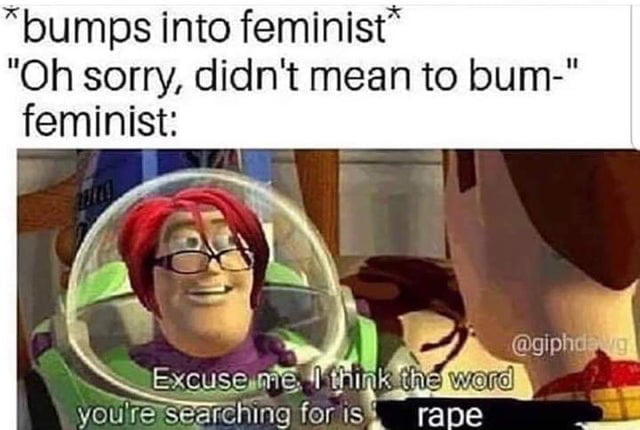

bumps into feminist* "Oh sorry, didn't mean to bum-" feminist: @giphdag Excuse me, I think the word rape you're searching for is
For n_clusters = 1 The average silhouette_score is : 0.1327758298098952
For n_clusters = 2 The average silhouette_score is : 0.27630233201350185
For n_clusters = 3 The average silhouette_score is : 0.402929646442916
For n_clusters = 4 The average silhouette_score is : 0.337982943695177
For n_clusters = 5 The average silhouette_score is : 0.41181466751200885
For n_clusters = 6 The average silhouette_score is : 0.40873123609085354
For n_clusters = 7 The average silhouette_score is : 0.3866915744161816
For n_clusters = 8 The average silhouette_score is : 0.3592420520449591
For n_clusters = 9 The average silhouette_score is : 0.3752666278393187
Best score : 0.41181466751200885  Number Of Clusters: 5
7.0 10.259456634521484
bumps w oh sorrys feminist
157.0 8.0
into feminist didnt mean
418.0 57.0
to bum d
399.0 333.0
agiphd the woro rape
74.81742858886719 368.0
excu

In [162]:
work('9998.jpg')